# "virtual QTL as a way to evaluate the power of a model in the genomic context"


## saved into "QTL_analysis1.py"

In [68]:
from imports2 import *
from neural_network_1_architecture_sprint_code_2019_07_28 import *

NUMERIC_SCALED_MERGED_FILE_NAME = f'{DATA_DIR}2019_07_24_GENE_DATA_numeric_merged_large.parquet'


if not 'genemap' in globals():
    genemap = generate_gene_to_genome_map()
    gene_data = pd.read_parquet(NUMERIC_SCALED_MERGED_FILE_NAME)
    
# ---------------------------------------------------------
if not 'model' in globals():
    FILE_PREFIX = '2019_07_experiments/2019_07_30_train_large_network_5'
    MODEL_FILE = f'{FILE_PREFIX}.h5'
    ARCHITECTURE = [3000] * 5
    LOSS = 'mse'
    OPTIMIZER = 'adam'
    model = Gene_to_trait_model(layers_size = ARCHITECTURE, optimizer = OPTIMIZER, loss = LOSS)
    model.load_weights(MODEL_FILE)
    
    
# -------------------------
def get_genes_in_virtual_QTL(Entry:"uniprot_id", genemap = None, QTL_size:int = 10**6, n_genes:int = None):
    '''returns a list of genes around specific uniprot Entry. either with baspairs "QTL_size" or n genes '''
    pos = genemap[genemap['Entry'] == Entry]
    if len(pos) == 0: return []
    
    org, chromosome, chrstart = pos.values[0][1:4]
    
    chrom = (genemap[ (genemap['Organism ID'] == org) 
                    & (genemap['chromosome']  == chromosome)]
             .sort_values('chrstart')).copy()
    
    if n_genes == None:
        qtl_start = max((chrstart - QTL_size / 2, 0))
        qtl_end   = chrstart + QTL_size / 2
    
        qtl = chrom[  (chrom['chrstart'] >= qtl_start) 
                    & (chrom['chrstop']  <= qtl_end)]
        return chrom, qtl
    else: # use n_genes and not chromose bp sizes...
        gene_pos = chrom['Entry'].values.tolist().index(Entry)
        half_n_genes = int(n_genes /  2)
        return chrom, chrom.iloc[gene_pos - half_n_genes: gene_pos + half_n_genes]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


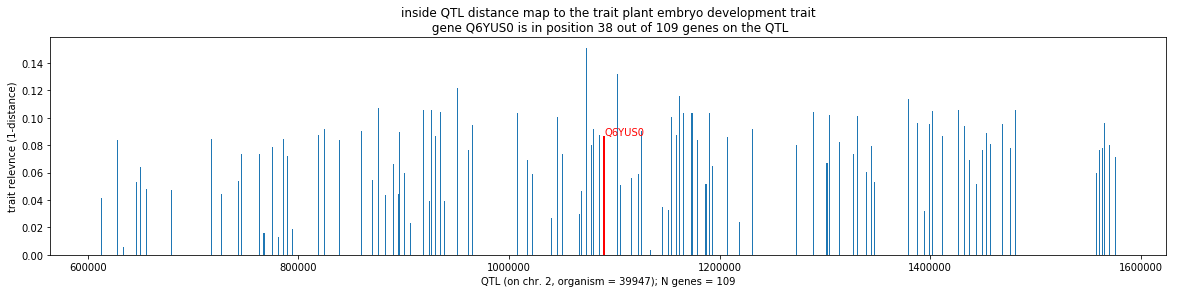

In [88]:
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

def grade_genes_to_trait(qtl:'genes_df', trait:str, model, gene_data, target_gene=None):
    entries = qtl['Entry'].values
    X = gene_data[gene_data.Entry_0.isin(entries)]
    predicted = model.predict(X.values[:, 1:])
    train_embedding = emb_map[emb_map.index == trait]
    cos_dist = cosine_distances(predicted, train_embedding).ravel()
    col_name = f'cos_dist : {trait}'
    qtl[col_name] = cos_dist
    qtl = qtl.sort_values(col_name)
    
    if not target_gene is None:
        position_in_list = qtl# qtl.drop_duplicates(subset=['chrstart'])
        position_in_list = position_in_list['Entry'].values.tolist().index(target_gene)
        return qtl, position_in_list
    
    return qtl


def visualize_qtl_to_trait(target_gene, genemap, trait, model, gene_data, QTL_size=10**6):
    chrom, qtl = get_genes_in_virtual_QTL(target_gene, genemap=genemap, QTL_size=QTL_size)
    sorted_qtl, position_in_list = grade_genes_to_trait(qtl, trait, model, gene_data, target_gene)
    sorted_qtl = sorted_qtl.copy()
    
    sorted_qtl['relevance'] = 1 - sorted_qtl[f'cos_dist : {trait}']
    sorted_qtl['relevance'] = sorted_qtl['relevance'] - sorted_qtl['relevance'].min()
    gene = sorted_qtl[sorted_qtl['Entry'] == target_gene]

    plt.figure(figsize=[20, 4])
    plt.bar(sorted_qtl['chrstart'], sorted_qtl['relevance'], width=1000)

    gene_color = 'red'
    plt.bar(gene['chrstart'], gene['relevance'], width=2000, color=gene_color)
    entry, org, chro, cstart, cstop, cos_dist, rel = gene.values[0]
    plt.text(cstart, rel, target_gene, color=gene_color)


    plt.xlabel(f'QTL (on chr. {sorted_qtl.chromosome.values[0]}, organism = {org}); N genes = {len(sorted_qtl)}')
    plt.ylabel(f'trait relevnce (1-distance)')
    
    message = f'gene {target_gene} is in position {position_in_list} out of {len(sorted_qtl)} genes on the QTL'
    plt.title(f'inside QTL distance map to the trait {trait}\n {message}')
    return sorted_qtl, position_in_list


target_gene = 'Q6YUS0'
trait = 'plant embryo development trait'
sorted_qtl, position_in_list = visualize_qtl_to_trait(target_gene, genemap, trait, model, gene_data)


In [140]:
if not 'X_train' in globals():
    X_train, Y_train, X_valid, Y_valid = data_loading('2019_07_30')

gene_trait = pd.DataFrame({'Entry' : X_valid.index, 'TO' : Y_valid.index})
gene_trait.sort_values('TO')

gene_trait[gene_trait['TO'] == 'plant embryo development trait']

Entry                              TO
11   A0A178UZG0  plant embryo development trait
12   A0A178V474  plant embryo development trait
16   A0A1P8BCC6  plant embryo development trait
37       F4Y589  plant embryo development trait
50       O49354  plant embryo development trait
54       P92969  plant embryo development trait
55       P93033  plant embryo development trait
56       P93736  plant embryo development trait
88       Q5FV38  plant embryo development trait
118      Q6YUS0  plant embryo development trait
147      Q8W4E1  plant embryo development trait
156      Q9FF86  plant embryo development trait
172      Q9M876  plant embryo development trait

# check the theoretical rank of a genes to the trait, within the virtual QTL

In [93]:
results = []
for entry, trait in tqdm(gene_trait.values):
    try:
        chrom, qtl = get_genes_in_virtual_QTL(entry, genemap=genemap)
        sorted_qtl, position_in_list = grade_genes_to_trait(qtl, trait, model, gene_data, entry)
        results.append([entry, trait, position_in_list, len(sorted_qtl)])
    except:
        print(f"problem with entry {entry}")
results = pd.DataFrame(results, columns = ['Entry', 'TO', 'pos_in_qtl', 'n_genes_in_qtl'])    
results

problem with entry A0A0N7KEX5
problem with entry A0A0N7KIZ1
problem with entry A0A0P0UZA9
problem with entry A0A0P0VFD3
problem with entry A0A0P0VSP9
problem with entry A0A0P0WDD9
problem with entry A0A0P0WYN6
problem with entry A0A0P0XHX9
problem with entry A0A0P0XRJ8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry A0A0U4C4X8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry A0A178W5M1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry A0A3Q7F946


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry A0A3Q7H318
problem with entry A0A3Q7HC54


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry A2ZFY7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry B3IYE3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry F4Y589
problem with entry F4Y595


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry H9CWE9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry P59082


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q0DXS3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry Q0J7U6
problem with entry Q0J8Q3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry Q0P1A8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q19VE6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q2R8L1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry Q32ZJ3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry Q40691


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q5VMP0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


problem with entry Q5ZPV8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q6K7E6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q6QHJ9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q76C22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q9LWU9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

problem with entry Q9XGF5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Entry                                            TO  pos_in_qtl  \
0    A0A0P0Y5F3                     fungal disease resistance           4   
1    A0A178UZG0                plant embryo development trait         298   
2    A0A178V474                plant embryo development trait         351   
3    A0A1B0SZS0                                  plant height           9   
4    A0A1P8B0U7                      meiotic cell cycle trait         479   
5    A0A1P8BCC6                plant embryo development trait         217   
6    A0A3Q7F295                     fungal disease resistance           6   
7    A0A3Q7GM10            fruit growth and development trait          38   
8    A0A3Q7IRG8                      viral disease resistance          34   
9    A0A3Q7J3I2                                male sterility          12   
10       A3AZ88                     fungal disease resistance          81   
11       B0F6T5                      viral disease resistance          10   
12       B0F832                    protist disease resistance           0   
13       B9DFU2                                    phyllotaxy         133   
14       B9DH42                  sterility or fertility trait          93   
15       C8C507                        fruit morphology trait          13   
16       E0XN34                          fruit ripening trait          25   
17       E3VXF2                  sterility or fertility trait          70   
18       F4I7I0                         enzyme activity trait         425   
19       F4I7W2                   chemical stress sensitivity          57   
20       F4IRR2                         leaf trichome density         266   
21       F7J0M6                            disease resistance          31   
22       F9W301                              cell cycle trait          31   
23       I7GYG6                                  plant height           4   
24       J9Q173                            disease resistance          13   
25       O04331                          relative growth rate         405   
26       O04619                                    root shape         148   
27       O04681                  bacterial disease resistance          11   
28       O24023                         abscisic acid content          27   
29       O24629                           chlorophyll content           1   
..          ...                                           ...         ...   
129      Q9LE63                                    leaf gloss         303   
130      Q9LFD2                                    seed color         199   
131      Q9LGE3                        root development trait          39   
132      Q9LJL3                         leaf morphology trait         381   
133      Q9LJR3                     far red light sensitivity         375   
134      Q9LKV7                             fruit yield trait          13   
135      Q9LNJ4                      flower development trait         355   
136      Q9LX33  plant structure growth and development trait         340   
137      Q9M1S8                     abscisic acid sensitivity         368   
138      Q9M876                plant embryo development trait         504   
139      Q9S757                             root hair density         294   
140      Q9S7R4                                     leaf size          85   
141      Q9SAK4                             light sensitivity         407   
142      Q9SFD8             endosperm storage protein content          80   
143      Q9SJX7                   phototropism response trait         450   
144      Q9SRX9                           anthocyanin content         195   
145      Q9SS48             seed growth and development trait         524   
146      Q9STX9                          nutrient sensitivity         263   
147      Q9SZD4                        root development trait         283   
148      Q9SZJ5                          flowering time trait         254   
149   

In [110]:
results['relative pos'] = 1 - results['pos_in_qtl'] / results['n_genes_in_qtl']
results

Entry                                            TO  pos_in_qtl  \
0    A0A0P0Y5F3                     fungal disease resistance           4   
1    A0A178UZG0                plant embryo development trait         298   
2    A0A178V474                plant embryo development trait         351   
3    A0A1B0SZS0                                  plant height           9   
4    A0A1P8B0U7                      meiotic cell cycle trait         479   
5    A0A1P8BCC6                plant embryo development trait         217   
6    A0A3Q7F295                     fungal disease resistance           6   
7    A0A3Q7GM10            fruit growth and development trait          38   
8    A0A3Q7IRG8                      viral disease resistance          34   
9    A0A3Q7J3I2                                male sterility          12   
10       A3AZ88                     fungal disease resistance          81   
11       B0F6T5                      viral disease resistance          10   
12       B0F832                    protist disease resistance           0   
13       B9DFU2                                    phyllotaxy         133   
14       B9DH42                  sterility or fertility trait          93   
15       C8C507                        fruit morphology trait          13   
16       E0XN34                          fruit ripening trait          25   
17       E3VXF2                  sterility or fertility trait          70   
18       F4I7I0                         enzyme activity trait         425   
19       F4I7W2                   chemical stress sensitivity          57   
20       F4IRR2                         leaf trichome density         266   
21       F7J0M6                            disease resistance          31   
22       F9W301                              cell cycle trait          31   
23       I7GYG6                                  plant height           4   
24       J9Q173                            disease resistance          13   
25       O04331                          relative growth rate         405   
26       O04619                                    root shape         148   
27       O04681                  bacterial disease resistance          11   
28       O24023                         abscisic acid content          27   
29       O24629                           chlorophyll content           1   
..          ...                                           ...         ...   
129      Q9LE63                                    leaf gloss         303   
130      Q9LFD2                                    seed color         199   
131      Q9LGE3                        root development trait          39   
132      Q9LJL3                         leaf morphology trait         381   
133      Q9LJR3                     far red light sensitivity         375   
134      Q9LKV7                             fruit yield trait          13   
135      Q9LNJ4                      flower development trait         355   
136      Q9LX33  plant structure growth and development trait         340   
137      Q9M1S8                     abscisic acid sensitivity         368   
138      Q9M876                plant embryo development trait         504   
139      Q9S757                             root hair density         294   
140      Q9S7R4                                     leaf size          85   
141      Q9SAK4                             light sensitivity         407   
142      Q9SFD8             endosperm storage protein content          80   
143      Q9SJX7                   phototropism response trait         450   
144      Q9SRX9                           anthocyanin content         195   
145      Q9SS48             seed growth and development trait         524   
146      Q9STX9                          nutrient sensitivity         263   
147      Q9SZD4                        root development trait         283   
148      Q9SZJ5                          flowering time trait         254   
149   

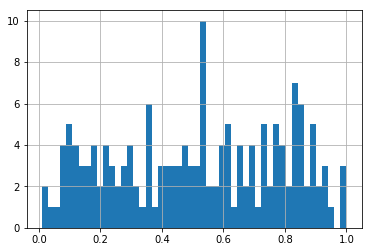

In [111]:
results['relative pos'].hist(bins=50)

In [112]:
results.groupby('TO').mean().sort_values('relative pos', ascending=False)

pos_in_qtl  \
TO                                                               
multi-tissue plant structure growth and develop...    4.000000   
gibberellic acid sensitivity                          7.000000   
plant color                                          59.000000   
protist disease resistance                           47.000000   
biotic stress trait                                  58.000000   
copper content trait                                 11.000000   
chlorophyll content                                  11.000000   
multi-tissue plant structure morphology trait        12.000000   
chemical stress sensitivity                          57.000000   
leaf size                                            85.000000   
leaf lamina length                                   14.000000   
non photochemical quenching                          65.000000   
male sterility                                       12.000000   
endosperm storage protein content                    80.000000   
cell elongation trait                                88.000000   
plant cell morphology trait                          99.000000   
floral organ development trait                       19.000000   
plant structure morphology trait                     10.000000   
grain number                                         14.000000   
leaf number                                          87.000000   
fruit morphology trait                               13.000000   
anthocyanin content                                 195.000000   
leaf growth and development trait                    68.500000   
phyllotaxy                                          133.000000   
trichome morphology trait                           172.000000   
viral disease resistance                             15.666667   
heat tolerance                                      142.000000   
leaf senescence trait                                60.500000   
fruit ripening trait                                 25.000000   
fruit yield trait                                    24.500000   
...                                                        ...   
abscisic acid content                                27.000000   
male sterility type                                   9.000000   
root shape                                           95.500000   
leaf morphology trait                               213.500000   
plant structure growth and development trait        340.000000   
disease resistance                                  146.333333   
nutrient sensitivity                                263.000000   
endosperm quality                                    47.000000   
stem morphology trait                                60.000000   
copper concentration                                 75.000000   
cell cycle trait                                    222.500000   
far red light sensitivity                           214.000000   
plant growth and development trait                  126.000000   
leaf shape                                          185.000000   
abscisic acid sensitivity                           368.000000   
grain length                                         66.000000   
seed color                                          199.000000   
light sensitivity                                   407.000000   
days to flowering trait                             338.000000   
flower development trait                            201.000000   
leaf gloss                                          303.000000   
mineral and ion content trait                        48.000000   
enzyme activity trait                               243.500000   
grain size                                           22.000000   
seed growth and development trait                   524.000000   
phototropism response trait                         450.000000   
relative growth rate                                460.000000   
meiotic cell cycle trait                            479.000000   
germination rate          

In [116]:
results[results['TO'] == 'multi-tissue plant structure growth and development trait'].sort_values('relative pos')

Entry                                                 TO  pos_in_qtl  \
66  Q5W7C1  multi-tissue plant structure growth and develo...           4   

    n_genes_in_qtl  relative pos  
66              84      0.952381

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


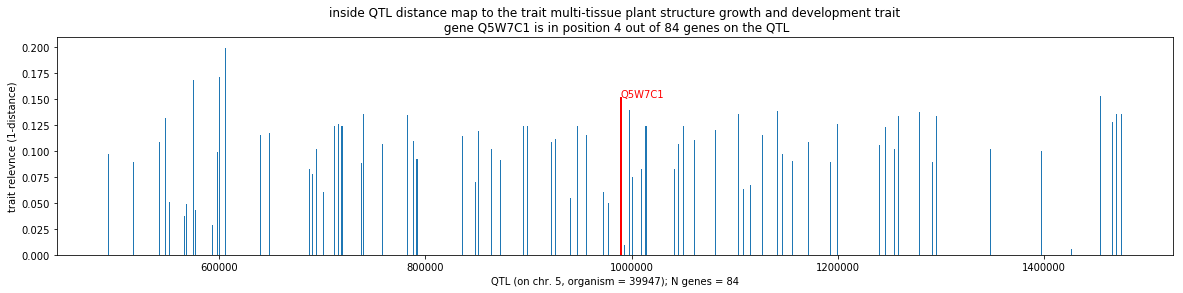

In [117]:
visualize_qtl_to_trait('Q5W7C1', genemap, 'multi-tissue plant structure growth and development trait', model, gene_data)
print()

# NEW DIRECTION: other measurment of gene-trait relevance

In [172]:
emb_map = pd.concat([Y_train, Y_valid], axis=0).drop_duplicates() 

def increase_trait_list_until_trait_in_list(Entry, trait, model):
    entries = qtl['Entry'].values
    X = gene_data[gene_data.Entry_0 == Entry]
    predicted = model.predict(X.values[:, 1:])
    pred_traits = embedding_to_traits(predicted, n_neigh=emb_map.shape[0], emb_map=emb_map)[0].tolist()
    return pred_traits.index(trait) + 1


def grade_genes_to_trait_by_position_of_first_match(qtl:'genes_df', trait:str, model, gene_data, target_gene=None):
    entries = qtl['Entry'].values
    print(len(entries))
    distances = [increase_trait_list_until_trait_in_list(Entry, trait, model) 
                 for Entry in tqdm(entries)]
        
    qtl[trait] = distances
    qtl = qtl.sort_values(trait)
    
    if not target_gene is None:
        position_in_list = qtl# qtl.drop_duplicates(subset=['chrstart'])
        position_in_list = position_in_list['Entry'].values.tolist().index(target_gene)
        return qtl, position_in_list
    
    return qtl

Entry = 'Q9XFM6'
trait = 'cell elongation trait'

chrom, qtl = get_genes_in_virtual_QTL(Entry, genemap)
result, gene_pos = grade_genes_to_trait_by_position_of_first_match(qtl, trait, model, gene_data, target_gene = Entry)

503


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [173]:
print(gene_pos)
result

4


Entry  Organism ID chromosome  chrstart   chrstop  \
36964  A0A178US14         3702          5  21598847  21600007   
45263      Q9FHB4         3702          5  21296832  21296832   
50608      F4KBW5         3702          5  20803105  20803105   
76939      F4KG44         3702          5  21212939  21214841   
7096       Q9XFM6         3702          5  21212939  21214841   
46792      Q9FHL9         3702          5  20978202  20978202   
41754      F4KBV6         3702          5  20783930  20783930   
9684       Q9LU60         3702          5  20783930  20783930   
81339  A0A1P8BFQ0         3702          5  21192096  21192096   
44140      Q9LTK7         3702          5  21182467  21182467   
47279      Q9FK18         3702          5  21598847  21600007   
88094  A0A178UJL2         3702          5  21444792  21444792   
82252  A0A178UGH0         3702          5  21634423  21636354   
80692      Q6NML4         3702          5  21296832  21296832   
13155      Q9LVV5         3702          5  21479381  21481255   
14342      Q9LVV3         3702          5  21483918  21485384   
46475  A0A178UJG6         3702          5  20871917  20872276   
33027  A0A1P8BFV7         3702          5  21323780  21323780   
4564       Q39111         3702          5  21055178  21055178   
37811      Q9ASY2         3702          5  21634423  21636354   
33022  A0A1P8BCI7         3702          5  20750512  20752114   
35426      F4KBT8         3702          5  20750512  20752114   
57461      B9DGI7         3702          5  20750512  20752114   
23246  A0A178UDX3         3702          5  21321427  21321427   
41564  A0A1P8BDH1         3702          5  21634423  21636354   
72010  A0A178UGD1         3702          5  20783930  20783930   
16540      Q9FHN3         3702          5  20921376  20922997   
62245      Q9FLX0         3702          5  21457533  21457533   
10834      Q9FYR7         3702          5  21307015  21309340   
1960       P92966         3702          5  21130319  21133708   
...           ...          ...        ...       ...       ...   
75928  A0A384LN43         3702          5  20820067  20820943   
8784       Q9FLX5         3702          5  21419589  21419589   
36391  A0A1P8BBM1         3702          5  20773234  20773234   
70504  A0A1P8BBJ5         3702          5  20773234  20773234   
63282      Q5HZ52         3702          5  20820067  20820943   
76853  A0A178UT93         3702          5  21020013  21022902   
31265  A0A1P8BBK0         3702          5  20773234  20773234   
1374       Q700C7         3702          5  21586218  21586218   
31027  A0A178UFN7         3702          5  21079105  21081631   
64855  A0A1P8BGA2         3702          5  21079105  21081631   
31895      Q9FLH6         3702          5  21079105  21081631   
41573  A0A178UF96         3702          5  21586218  21586218   
13241      Q9LU64         3702          5  20773234  20773234   
53167  A0A1P8BE01         3702          5  21586218  21586218   
45181      Q9FI47         3702          5  20744552  20745702   
27512  A0A178UGM8         3702          5  20744552  20745702   
87208      F4KDB4         3702          5  20967033  20968505   
84819      Q3E8D1         3702          5  20967033  20968505   
58072  A0A1P8BFG8         3702          5  20967033  20968505   
62655      A8MQZ2         3702          5  20967033  20968505   
10798      Q9XH75         3702          5  21286734  21288912   
53789  A0A1P8BDZ5         3702          5  21386726  21387713   
70316  A0A178UID0         3702          5  21386726  21387713   
7561       Q9LTE1         3702          5  21386726  21387713   
8450       Q9LTF7         3702          5  21343101  21343101   
43796      Q9LTF0         3702          5  21363485  21364400   
66895  A0A178USM9         3702          5  21363485  21364400   
25543  A0A1P8BBY2         3702          5  21382481  21383431   
13273      Q9LTE3         3702          5  21382481  21383431   
6489       Q06738         3702          5  2124

(123, 133)

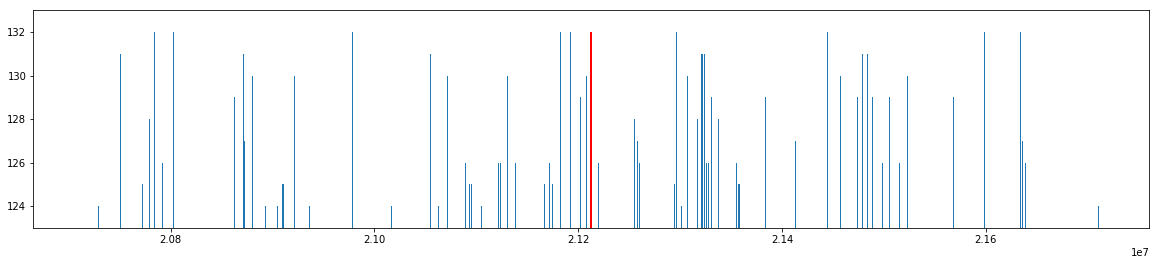

In [209]:
result['weight'] = (result[trait].max() - result[trait])
#result['weight'] = result['weight'] / result['weight'].max()
plt.figure(figsize=[20,4])
plt.bar(*result[['chrstart','weight']].T.values, width=1000)
gene_start, gene_weight = result[result['Entry'] == Entry][['chrstart','weight']].values[0]
plt.bar(x = [gene_start], height=[gene_weight], width=2000, color='red')
plt.ylim(result[trait].max()-10, result[trait].max())

Entry  Organism ID chromosome  chrstart   chrstop  \
chrstart                                                           
21598847  A0A178US14         3702          5  21598847  21600007   
21296832      Q9FHB4         3702          5  21296832  21296832   
20803105      F4KBW5         3702          5  20803105  20803105   
21212939      F4KG44         3702          5  21212939  21214841   
21212939      Q9XFM6         3702          5  21212939  21214841   
20978202      Q9FHL9         3702          5  20978202  20978202   
20783930      F4KBV6         3702          5  20783930  20783930   
20783930      Q9LU60         3702          5  20783930  20783930   
21192096  A0A1P8BFQ0         3702          5  21192096  21192096   
21182467      Q9LTK7         3702          5  21182467  21182467   
21598847      Q9FK18         3702          5  21598847  21600007   
21444792  A0A178UJL2         3702          5  21444792  21444792   
21634423  A0A178UGH0         3702          5  21634423  21636354   
21296832      Q6NML4         3702          5  21296832  21296832   
21479381      Q9LVV5         3702          5  21479381  21481255   
21483918      Q9LVV3         3702          5  21483918  21485384   
20871917  A0A178UJG6         3702          5  20871917  20872276   
21323780  A0A1P8BFV7         3702          5  21323780  21323780   
21055178      Q39111         3702          5  21055178  21055178   
21634423      Q9ASY2         3702          5  21634423  21636354   
20750512  A0A1P8BCI7         3702          5  20750512  20752114   
20750512      F4KBT8         3702          5  20750512  20752114   
20750512      B9DGI7         3702          5  20750512  20752114   
21321427  A0A178UDX3         3702          5  21321427  21321427   
21634423  A0A1P8BDH1         3702          5  21634423  21636354   
20783930  A0A178UGD1         3702          5  20783930  20783930   
20921376      Q9FHN3         3702          5  20921376  20922997   
21457533      Q9FLX0         3702          5  21457533  21457533   
21307015      Q9FYR7         3702          5  21307015  21309340   
21130319      P92966         3702          5  21130319  21133708   
...              ...          ...        ...       ...       ...   
20820067  A0A384LN43         3702          5  20820067  20820943   
21419589      Q9FLX5         3702          5  21419589  21419589   
20773234  A0A1P8BBM1         3702          5  20773234  20773234   
20773234  A0A1P8BBJ5         3702          5  20773234  20773234   
20820067      Q5HZ52         3702          5  20820067  20820943   
21020013  A0A178UT93         3702          5  21020013  21022902   
20773234  A0A1P8BBK0         3702          5  20773234  20773234   
21586218      Q700C7         3702          5  21586218  21586218   
21079105  A0A178UFN7         3702          5  21079105  21081631   
21079105  A0A1P8BGA2         3702          5  21079105  21081631   
21079105      Q9FLH6         3702          5  21079105  21081631   
21586218  A0A178UF96         3702          5  21586218  21586218   
20773234      Q9LU64         3702          5  20773234  20773234   
21586218  A0A1P8BE01         3702          5  21586218  21586218   
20744552      Q9FI47         3702          5  20744552  20745702   
20744552  A0A178UGM8         3702          5  20744552  20745702   
20967033      F4KDB4         3702          5  20967033  20968505   
20967033      Q3E8D1         3702          5  20967033  20968505   
20967033  A0A1P8BFG8         3702          5  20967033  20968505   
20967033      A8MQZ2         3702          5  20967033  20968505   
21286734      Q9XH75         3702          5  21286734  21288912   
21386726  A0A1P8BDZ5         3702          5  21386726  21387713   
21386726  A0A178UID0         3702          5  21386726  21387713   
21386726      Q9LTE1         3702          5  21386726  21387713   
21343101      Q9LTF7         3702          5  21343101  21343101   
21363485      Q9LTF0         3702          5  21363485  21364400   
213

In [210]:
FILE_PREFIX = '2019_07_experiments/2019_07_30_train_large_network_5'
RESULT_FILE = f'{FILE_PREFIX}_RESULTS.parquet'
res = pd.read_parquet(RESULT_FILE)
res

Entry                                            TO  in_top_1  \
0    A0A0N7KEX5                                  plant height         0   
1    A0A0N7KIZ1                          abiotic stress trait         0   
2    A0A0P0UZA9                          abiotic stress trait         0   
3    A0A0P0VFD3                      flower development trait         1   
4    A0A0P0VSP9                                  plant height         0   
5    A0A0P0WDD9                          abiotic stress trait         0   
6    A0A0P0WYN6                             drought tolerance         1   
7    A0A0P0XHX9                                  plant height         0   
8    A0A0P0XRJ8                             drought tolerance         0   
9    A0A0P0Y5F3                     fungal disease resistance         0   
10   A0A0U4C4X8                     fungal disease resistance         0   
11   A0A178UZG0                plant embryo development trait         1   
12   A0A178V474                plant embryo development trait         1   
13   A0A178W5M1                          relative growth rate         0   
14   A0A1B0SZS0                                  plant height         0   
15   A0A1P8B0U7                      meiotic cell cycle trait         1   
16   A0A1P8BCC6                plant embryo development trait         1   
17   A0A3Q7F295                     fungal disease resistance         0   
18   A0A3Q7F946                            disease resistance         1   
19   A0A3Q7GM10            fruit growth and development trait         1   
20   A0A3Q7H318                inflorescence morphology trait         0   
21   A0A3Q7HC54                             auxin sensitivity         0   
22   A0A3Q7IRG8                      viral disease resistance         1   
23   A0A3Q7J3I2                                male sterility         1   
24       A2ZFY7                      flower development trait         0   
25       A3AZ88                     fungal disease resistance         0   
26       B0F6T5                      viral disease resistance         0   
27       B0F832                    protist disease resistance         0   
28       B3IYE3                      metabolite content trait         0   
29       B9DFU2                                    phyllotaxy         1   
..          ...                                           ...       ...   
164      Q9LGE3                        root development trait         0   
165      Q9LJL3                         leaf morphology trait         1   
166      Q9LJR3                     far red light sensitivity         1   
167      Q9LKV7                             fruit yield trait         1   
168      Q9LNJ4                      flower development trait         0   
169      Q9LWU9                                  plant height         0   
170      Q9LX33  plant structure growth and development trait         0   
171      Q9M1S8                     abscisic acid sensitivity         0   
172      Q9M876                plant embryo development trait         1   
173      Q9S757                             root hair density         1   
174      Q9S7R4                                     leaf size         0   
175      Q9SAK4                             light sensitivity         0   
176      Q9SFD8             endosperm storage protein content         0   
177      Q9SJX7                   phototropism response trait         1   
178      Q9SRX9                           anthocyanin content         1   
179      Q9SS48             seed growth and development trait         1   
180      Q9STX9                          nutrient sensitivity         0   
181      Q9SZD4                        root development trait         0   
182      Q9SZJ5                          flowering time trait         0   
183      Q9XF67                              oxidative stress         1   
184      Q9XFM6                         cell elongation trait         1   
185      Q9XGF5                    

In [214]:
# Entry = 'Q9XGX0'
# trait = 'plant height'

# chrom, qtl = get_genes_in_virtual_QTL(Entry, genemap)
# result, gene_pos = grade_genes_to_trait_by_position_of_first_match(qtl, trait, model, gene_data, target_gene = Entry)

result['weight'] = (result[trait].max() - result[trait])
#result['weight'] = result['weight'] / result['weight'].max()
plt.figure(figsize=[20,4])
plt.bar(*result[['chrstart','weight']].T.values, width=1000)

top20 = result.sort_values('weight', ascending=False)[0:20]
plt.bar(*top20[['chrstart','weight']].T.values, width=1000, color='green')

gene_start, gene_weight = result[result['Entry'] == Entry][['chrstart','weight']].values[0]
plt.bar(x = [gene_start], height=[gene_weight], width=2000, color='red')

plt.ylim(result[trait].max()-30, result[trait].max())
display(result[0:20].style.bar())

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:960: RuntimeWarning: divide by zero encountered in long_scalars
  zero_normed = width * (0 - s.min()) / (s.max() - s.min())
